# Plotting Code for the WRF Single Column Model Output

In [1]:
%pylab inline
import wrf
import os
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
import scm_helper 

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1.) Copying the data over from our WRF run.

Once the `wrf.exe` is finished running, you should find a new file titled `wrfout_d01_1999-10-22_19:00:00`.

Because the data in the `WRF/test/em_scm_xy/` directory is not saved, you'll want to copy it over into a directory that will persist even after you logout of the JupyterHub.  Let's do that now.

In [2]:
output_file = "/home/jovyan/WRF/test/em_scm_xy/wrfout_d01_1999-10-22_19:00:00"
directory = "/home/jovyan/WRF_out/wrfout_ysu"
os.system(f"cp {output_file} {directory}")

0

## 2.) Loading in the data

The output file format from the WRF is usually in the NetCDF format.  This is a format that has multi-dimensional arrays.  There is also metadata that can help you understand the dimensions, units, etc.

Here we'll load in the dataset that we have obtained from our run of `./wrf.exe`.  This code will also determine what PBL scheme you used in your run.

In [3]:
d = Dataset('/home/jovyan/WRF_out/wrfout_ysu')
bl = scm_helper.get_pbl_name(d)
scheme = bl[1]

print("Your Boundary Layer Scheme:", bl)

Your Boundary Layer Scheme: ('YSU Scheme', 'YSU')


## 3.) Loading in variables from your single column model (SCM).

We'll now have to load in individual variables from our SCM run.  Let's load in a few different variables:

* potential temperature (theta)
* water vapor mixing ratio (qvapor)
* height
* u, v wind components.
* contributions to the temperature tendency from the PBL scheme.
* CAPE/CIN from the surface parcel

In [4]:
theta = wrf.getvar(d, 'theta', timeidx=wrf.ALL_TIMES)
qvapor = wrf.getvar(d, 'QVAPOR', timeidx=wrf.ALL_TIMES)
height = wrf.getvar(d, 'height', timeidx=wrf.ALL_TIMES)
u, v = wrf.getvar(d, 'uvmet', timeidx=wrf.ALL_TIMES)
pbl_theta = wrf.getvar(d, 'RTHBLTEN', timeidx=wrf.ALL_TIMES)
ci = wrf.getvar(d, 'cape_2d', timeidx=wrf.ALL_TIMES)

# Let's calculate the wind speed
wspd = np.sqrt(np.power(u[:,:,0,0].T, 2) + np.power(v[:,:,0,0].T, 2))

## 4.) Plotting Time x Height Cross Section for Potential Temperature

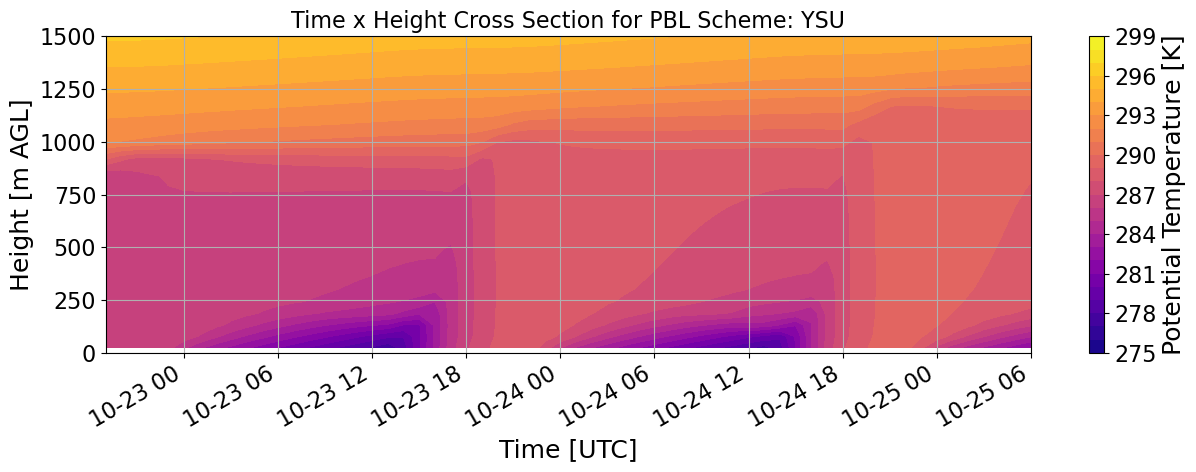

In [6]:
fig = figure(figsize=(13,5), facecolor='w')
title(f"Time x Height Cross Section for PBL Scheme: {scheme.upper()}")
c = contourf(theta.Time, height[0,:,0,0].T, theta[:,:,0,0].T, np.arange(275,300,1), cmap='plasma')
#barbs(theta.Time, height[0,:,0,0], u[:,:,0,0].T, v[:,:,0,0].T, wspd, cmap='Greys', length=4)
cb = colorbar(c)
cb.ax.set_ylabel("Potential Temperature [K]")
ylim(0,1500)
ylabel("Height [m AGL]")
xlabel("Time [UTC]")
grid()
fig.autofmt_xdate()
plt.tight_layout()
savefig("example.png", bbox_inches='tight')
show()

## 4.) Plotting Time x Height Cross Section for Potential Temperature Tendency from PBL Scheme

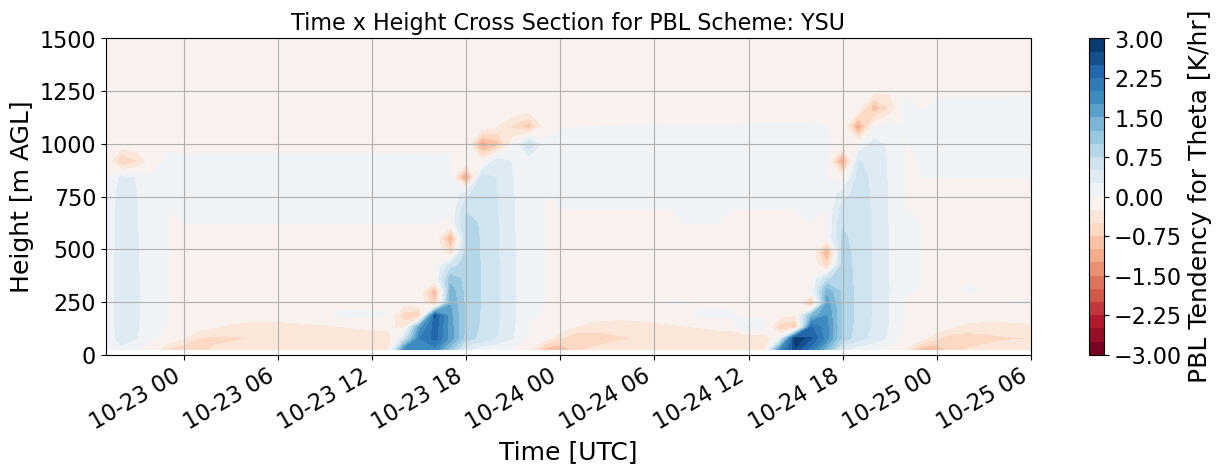

In [7]:
fig = figure(figsize=(13,5))
title(f"Time x Height Cross Section for PBL Scheme: {scheme.upper()}")
c = contourf(theta.Time, height[0,:,0,0].T, 3600*pbl_theta[:,:,0,0].T, np.arange(-3,3.25,.25), cmap='RdBu')
cb = colorbar(c)
cb.ax.set_ylabel("PBL Tendency for Theta [K/hr]")
ylim(0,1500)
ylabel("Height [m AGL]")
xlabel("Time [UTC]")
grid()
fig.autofmt_xdate()
plt.tight_layout()
show()

## 5.) Plotting Time x Height Cross Section for Water Vapor Mixing Ratio

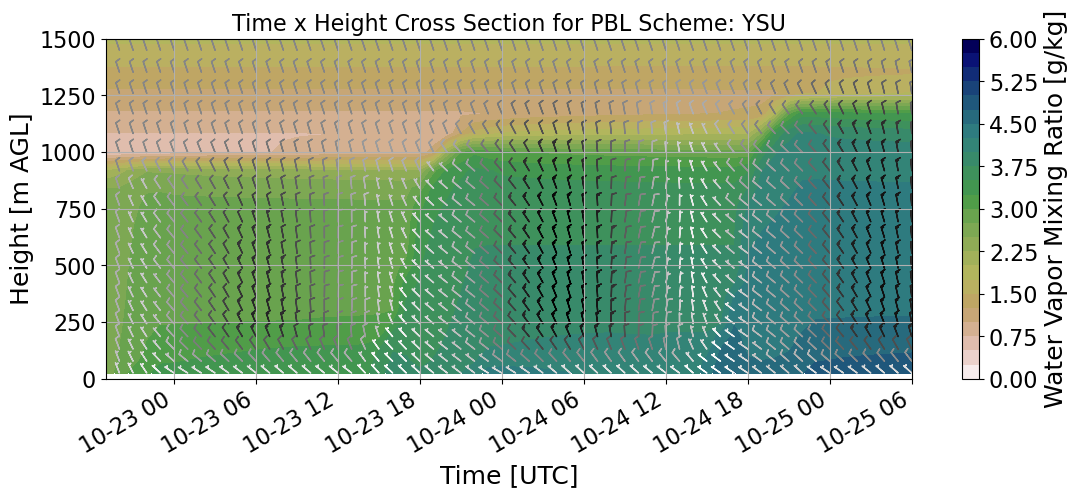

In [8]:
fig = figure(figsize=(13,5))
title(f"Time x Height Cross Section for PBL Scheme: {scheme.upper()}")
c = contourf(theta.Time, height[0,:,0,0].T, 1000*qvapor[:,:,0,0].T, np.arange(0,6.25,.25), cmap='gist_earth_r')
wspd = np.sqrt(np.power(u[:,:,0,0].T, 2) + np.power(v[:,:,0,0].T, 2))
barbs(theta.Time, height[0,:,0,0], u[:,:,0,0].T, v[:,:,0,0].T, wspd, cmap='Greys', length=4)
cb = colorbar(c)
cb.ax.set_ylabel("Water Vapor Mixing Ratio [g/kg]")
ylim(0,1500)
ylabel("Height [m AGL]")
xlabel("Time [UTC]")
grid()
fig.autofmt_xdate()
show()

## 6.) Plotting CAPE/CIN Time Series

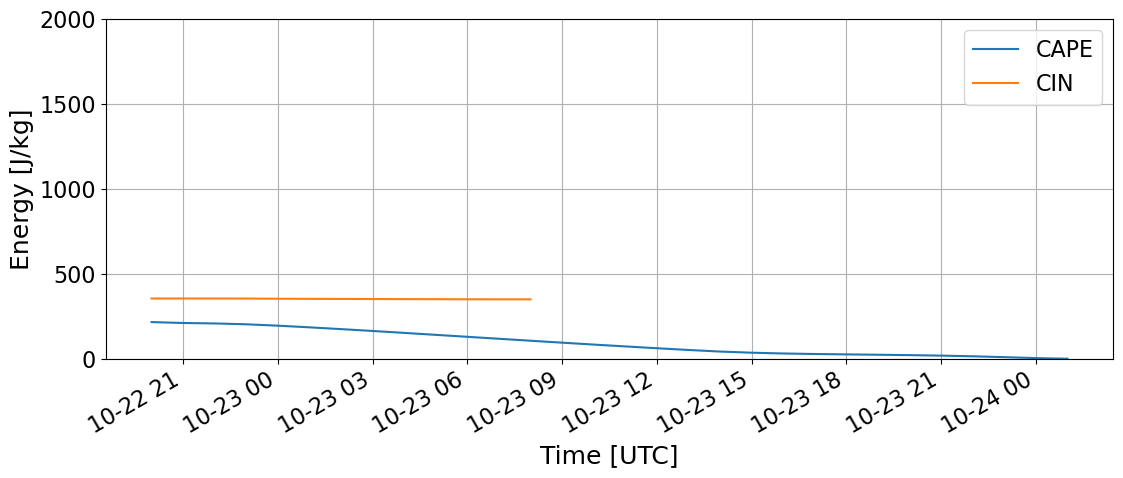

In [9]:
fig = figure(figsize=(13,5))
plot(theta.Time, ci[0,:,0,0], label='CAPE')
plot(theta.Time, ci[1,:,0,0], label='CIN')
legend(loc=0)
grid()
ylim(0,2000)
fig.autofmt_xdate()
xlabel("Time [UTC]")
ylabel("Energy [J/kg]")
show()